<a href="https://colab.research.google.com/github/sergiopaniego/BehaviorStudio-experiments/blob/main/BS_pilotnet_network_RGB_sequence_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# When using Colab, check the GPU that is assigned and reload the runtime if its memory is low
!nvidia-smi

Fri Feb 19 16:19:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls "/content/drive/My Drive"
!ls "/content/drive/My Drive/complete_dataset.zip"
!unzip "/content/drive/My Drive/curves_only.zip"
!unzip "/content/drive/My Drive/complete_dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: complete_dataset/Images/4655.png  
  inflating: complete_dataset/Images/13432.png  
  inflating: complete_dataset/Images/13393.png  
  inflating: complete_dataset/Images/14645.png  
  inflating: complete_dataset/Images/16896.png  
  inflating: complete_dataset/Images/4638.png  
  inflating: complete_dataset/Images/12695.png  
  inflating: complete_dataset/Images/13074.png  
  inflating: complete_dataset/Images/16020.png  
  inflating: complete_dataset/Images/15454.png  
  inflating: complete_dataset/Images/690.png  
  inflating: complete_dataset/Images/8168.png  
  inflating: complete_dataset/Images/4244.png  
  inflating: complete_dataset/Images/16078.png  
  inflating: complete_dataset/Images/6062.png  
  inflating: complete_dataset/Images/7468.png  
  inflating: complete_dataset/Images/1326.png  
  inflating: complete_dataset/Images/2106.png  
  inflating: complete_dataset/Images/585.png  
  inflating: complete_dataset/

In [6]:
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


def load_data(folder):
    name_folder = '/content/' + folder + '/Images/'
    list_images = glob.glob(name_folder + '*')
    print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[4].split('.png')[0]))
    name_file = '/content/' + folder + '/data.json'
    file = open(name_file, 'r')
    data = file.read()
    file.close()
    return images, data

def get_images(list_images, type_image, array_imgs):
    # Read the images
    for name in list_images:
        img = cv2.imread(name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        array_imgs.append(img)

    return array_imgs

def parse_json(data, array):
    # Process json
    data_parse = data.split('}')[:-1]
    for d in data_parse:
        v = d.split('"v": ')[1]
        d_parse = d.split(', "v":')[0]
        w = d_parse.split(('"w": '))[1]
        array.append((float(v), float(w)))

    return array

def preprocess_data(array, imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    flip_imgs = []
    array_flip = []
    for i in range(len(array)):
        flip_imgs.append(cv2.flip(imgs[i], 1))
        array_flip.append((array[i][0], -array[i][1]))
    new_array = array + array_flip
    new_array_imgs = imgs + flip_imgs
    return new_array, new_array_imgs


# Load data
images, data = load_data('complete_dataset')
images_curve, data_curve = load_data('curves_only')

# CHANGE type_image
type_image = 'cropped'
#type_image='normal'

# Preprocess images
array_imgs = []
array_imgs = get_images(images, type_image, array_imgs)
array_imgs = get_images(images_curve, type_image, array_imgs)
# Preprocess json
array_annotations = []
array_annotations = parse_json(data, array_annotations)
array_annotations = parse_json(data_curve, array_annotations)


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)


# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
# x = x[:]


# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
  array_annotations_v.append(annotation[0])
  array_annotations_w.append(annotation[1])
  
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
# normalized_Y = normalize(array_annotations_w)
old_min = array_annotations_w.min()
old_range = array_annotations_w.max() - old_min

new_min = -1
new_range = 2
normalized_Y = [(n - old_min) / old_range * new_range + new_min for n in array_annotations_w]
normalized_Y = np.array(normalized_Y)

normalized_annotations = []
for i in range(0, len(normalized_X)):
  normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)
array_annotations = normalized_annotations
# END NORMALIZE DATA

split_test_train_value = 0.30
#images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_imgs, array_annotations, test_size=0.30, random_state=42)
# FOR LSTMs -> suffle=False because the order of images is relevant
images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_imgs, array_annotations, test_size=split_test_train_value, random_state=42, shuffle=False)
#images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_2_images, array_annotations, test_size=0.30, random_state=42)

# Adapt the data
images_train = np.stack(images_train, axis=0)
annotations_train = np.stack(annotations_train, axis=0)
images_validation = np.stack(images_validation, axis=0)
annotations_validation = np.stack(annotations_validation, axis=0)

print(annotations_train[0])
print(annotations_train.shape)

#video = np.stack(array_imgs, axis=0)
print(images_train.shape)
print(images_validation.shape)


['/content/complete_dataset/Images/14566.png', '/content/complete_dataset/Images/2390.png', '/content/complete_dataset/Images/5582.png', '/content/complete_dataset/Images/10563.png', '/content/complete_dataset/Images/6885.png', '/content/complete_dataset/Images/7276.png', '/content/complete_dataset/Images/9640.png', '/content/complete_dataset/Images/10976.png', '/content/complete_dataset/Images/2752.png', '/content/complete_dataset/Images/446.png', '/content/complete_dataset/Images/13466.png', '/content/complete_dataset/Images/4146.png', '/content/complete_dataset/Images/3116.png', '/content/complete_dataset/Images/14736.png', '/content/complete_dataset/Images/5293.png', '/content/complete_dataset/Images/14809.png', '/content/complete_dataset/Images/7479.png', '/content/complete_dataset/Images/1370.png', '/content/complete_dataset/Images/7885.png', '/content/complete_dataset/Images/3128.png', '/content/complete_dataset/Images/11123.png', '/content/complete_dataset/Images/10497.png', '/

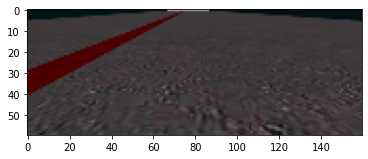

In [7]:
img = images_train[5000]
imgplot = plt.imshow(img)
plt.show()

In [8]:
# SEPARATE DATASET INTO SEQUENCES TO FIT BATCH SIZES
# 1
array_1_img = [] 
array_1_ann = []
# 2
array_2_img = [] 
array_2_ann = []
# 3
array_3_img = [] 
array_3_ann = []
# 4
array_4_img = [] 
array_4_ann = []
# 5
array_5_img = [] 
array_5_ann = []
# 6
array_6_img = [] 
array_6_ann = []
# 7
array_7_img = [] 
array_7_ann = []
# 8
array_8_img = [] 
array_8_ann = []
# 9
array_9_img = [] 
array_9_ann = []
# 10
array_10_img = [] 
array_10_ann = []
# 11
array_11_img = [] 
array_11_ann = []
# 12
array_12_img = [] 
array_12_ann = []
# 13
array_13_img = [] 
array_13_ann = []
# 14
array_14_img = [] 
array_14_ann = []
# 15
array_15_img = [] 
array_15_ann = []
# 16
array_16_img = [] 
array_16_ann = []
# 17
array_17_img = [] 
array_17_ann = []
# 18
array_18_img = [] 
array_18_ann = []
# 19
array_19_img = [] 
array_19_ann = []
# 20
array_20_img = [] 
array_20_ann = []
# 21
array_21_img = [] 
array_21_ann = []
# 22
array_22_img = [] 
array_22_ann = []
# 23
array_23_img = [] 
array_23_ann = []
# 24
array_24_img = [] 
array_24_ann = []
# 25
array_25_img = [] 
array_25_ann = []
# 26
array_26_img = [] 
array_26_ann = []
# 27
array_27_img = [] 
array_27_ann = []
# 28
array_28_img = [] 
array_28_ann = []
# 29
array_29_img = [] 
array_29_ann = []
# 30
array_30_img = [] 
array_30_ann = []
# 31
array_31_img = [] 
array_31_ann = []
# 32
array_32_img = [] 
array_32_ann = []
# 33
array_33_img = [] 
array_33_ann = []


'''
Dataset completo:

3744-3745
5066-5067
9720-9721
10387-10388
10695-10696
11283-11284
11354-11355
11492-11493
11980-11981
12618-12619
13231-13232
14107-14108
15790-15791
16732-16762 -> giro total???
16795-16796
16796-17341
Dataset muchas curvas:
(17341+...)
3156-3157

Cortes: 
1. 0-3700 *
2. 3745-5045 *
3. 5067-9717 *
4. 9721-10371 *
5. 10388-10688 *
6. 10696-11246 *
7. 11284-11334 *
8. 11355-11455 *
9. 11493-11943 *
10. 11981-12581 *
11. 12619-13219 *
12. 13232-14082 *
13. 14108-15758 *
14. 15791-16691 *
15. 16796-17296 *
16. 17341-20491 *
17. 20498-22598 *
Repetición cortes:
1. 22609-26309 *
2. 26354-27654 *
3. 27676-32326 *
4. 32330-32960 *
5. 32997-33297 *
6. 33305-33855 *
7. 33893-33943 *
8. 33964-34064 *
9. 34102-34552 *
10. 34590-35190 *
11. 35228-35828 *
12. 35841-36691 *
13. 36717-38367 *
14. 38400-39300 *
15. 39405-39905 *
16. 39950-43100 *
17. 43107-45207 *


'''


for i in range(0, 3700):
  array_1_img.append(array_imgs[i])
  array_1_ann.append(array_annotations[i])
for i in range(3745, 5045):
  array_2_img.append(array_imgs[i])
  array_2_ann.append(array_annotations[i])
for i in range(5067, 9717):
  array_3_img.append(array_imgs[i])
  array_3_ann.append(array_annotations[i])
for i in range(9721, 10371):
  array_4_img.append(array_imgs[i])
  array_4_ann.append(array_annotations[i])
for i in range(10388, 10688):
  array_5_img.append(array_imgs[i])
  array_5_ann.append(array_annotations[i])
for i in range(10696, 11246):
  array_6_img.append(array_imgs[i])
  array_6_ann.append(array_annotations[i])
for i in range(11284, 11334):
  array_7_img.append(array_imgs[i])
  array_7_ann.append(array_annotations[i])
for i in range(11355, 11455):
  array_8_img.append(array_imgs[i])
  array_8_ann.append(array_annotations[i])
for i in range(11493, 11943):
  array_9_img.append(array_imgs[i])
  array_9_ann.append(array_annotations[i])
for i in range(11981, 12581):
  array_10_img.append(array_imgs[i])
  array_10_ann.append(array_annotations[i])
for i in range(12619, 13219):
  array_11_img.append(array_imgs[i])
  array_11_ann.append(array_annotations[i])
for i in range(13232, 14082):
  array_12_img.append(array_imgs[i])
  array_12_ann.append(array_annotations[i])
for i in range(14108, 15758):
  array_13_img.append(array_imgs[i])
  array_13_ann.append(array_annotations[i])
for i in range(15791, 17296):
  array_14_img.append(array_imgs[i])
  array_14_ann.append(array_annotations[i])
for i in range(17341, 20491):
  array_15_img.append(array_imgs[i])
  array_15_ann.append(array_annotations[i])
for i in range(20498, 22598):
  array_16_img.append(array_imgs[i])
  array_16_ann.append(array_annotations[i])
for i in range(22609, 26309):
  array_17_img.append(array_imgs[i])
  array_17_ann.append(array_annotations[i])
for i in range(26354, 27654):
  array_18_img.append(array_imgs[i])
  array_18_ann.append(array_annotations[i])
for i in range(27676, 32326):
  array_19_img.append(array_imgs[i])
  array_19_ann.append(array_annotations[i])
for i in range(32330, 32960):
  array_20_img.append(array_imgs[i])
  array_20_ann.append(array_annotations[i])
for i in range(32997, 33297):
  array_21_img.append(array_imgs[i])
  array_21_ann.append(array_annotations[i])
for i in range(33305, 33855):
  array_22_img.append(array_imgs[i])
  array_22_ann.append(array_annotations[i])
for i in range(33893, 33943):
  array_23_img.append(array_imgs[i])
  array_23_ann.append(array_annotations[i])
for i in range(33964, 34064):
  array_24_img.append(array_imgs[i])
  array_24_ann.append(array_annotations[i])
for i in range(34102, 34552):
  array_25_img.append(array_imgs[i])
  array_25_ann.append(array_annotations[i])
for i in range(34590, 35190):
  array_26_img.append(array_imgs[i])
  array_26_ann.append(array_annotations[i])
for i in range(35228, 35828):
  array_27_img.append(array_imgs[i])
  array_27_ann.append(array_annotations[i])
for i in range(35841, 36691):
  array_28_img.append(array_imgs[i])
  array_28_ann.append(array_annotations[i])
for i in range(36717, 38367):
  array_29_img.append(array_imgs[i])
  array_29_ann.append(array_annotations[i])
for i in range(38400, 39300):
  array_30_img.append(array_imgs[i])
  array_30_ann.append(array_annotations[i])
for i in range(39405, 39905):
  array_31_img.append(array_imgs[i])
  array_31_ann.append(array_annotations[i])
for i in range(39950, 43100):
  array_32_img.append(array_imgs[i])
  array_32_ann.append(array_annotations[i])
for i in range(43107, 45207):
  array_33_img.append(array_imgs[i])
  array_33_ann.append(array_annotations[i])
   



new_array_imgs = array_1_img+array_2_img+array_3_img+array_4_img+array_5_img \
  +array_6_img+array_7_img+array_8_img+array_9_img+array_10_img+array_11_img \
  +array_12_img+array_13_img+array_14_img+array_15_img+array_16_img+array_17_img \
  +array_18_img+array_19_img+array_20_img+array_21_img+array_22_img+array_23_img \
  +array_24_img+array_25_img+array_26_img+array_27_img+array_28_img \
  +array_29_img+array_30_img+array_31_img+array_32_img+array_33_img
new_array_annotations = array_1_ann+array_2_ann+array_3_ann+array_4_ann \
  +array_5_ann+array_6_ann+array_7_ann+array_8_ann+array_9_ann+array_10_ann \
  +array_11_ann+array_12_ann+array_13_ann+array_14_ann+array_15_ann+array_16_ann \
  +array_17_ann+array_18_ann+array_19_ann+array_20_ann+array_21_ann+array_22_ann \
  +array_23_ann+array_24_ann+array_25_ann+array_26_ann+array_27_ann+array_28_ann \
  +array_29_ann+array_30_ann+array_31_ann+array_32_ann+array_33_ann

print(len(new_array_imgs))
print(len(new_array_annotations))

images_train, images_validation, annotations_train, annotations_validation = train_test_split(new_array_imgs, new_array_annotations, test_size=0.30, random_state=42, shuffle=False)
#images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_2_images, array_annotations, test_size=0.30, random_state=42)

# Adapt the data
images_train = np.stack(images_train, axis=0)
annotations_train = np.stack(annotations_train, axis=0)
images_validation = np.stack(images_validation, axis=0)
annotations_validation = np.stack(annotations_validation, axis=0)

print(len(new_array_annotations))
print(annotations_train[0])
print(annotations_train.shape)

#video = np.stack(array_imgs, axis=0)
print(images_train.shape)
print(images_validation.shape)

44285
44285
44285
[1.         0.00947395]
(30999, 2)
(30999, 60, 160, 3)
(13286, 60, 160, 3)


In [9]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, BatchNormalization, Dropout, ConvLSTM2D, Reshape, Activation, MaxPooling2D
from keras.layers import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Adam


def pilotnet_model(img_shape):
    '''
    Model of End to End Learning for Self-Driving Cars (NVIDIA)
    '''
    model = Sequential()
    model.add(BatchNormalization(epsilon=0.001, axis=-1, input_shape=img_shape))
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation="relu",padding='same'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation="relu",padding='same'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation="relu",padding='same'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu",padding='same'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu",padding='same'))
    model.add(Flatten())
    model.add(Dense(1164, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(2))
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss="mse", metrics=['accuracy', 'mse', 'mae'])
    return model

In [10]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)
print(images_train[0].shape)
print(annotations_train[0])
#print(img_shape)
img_shape = (60, 160, 3)
print(img_shape)


timesteps = 1
batch_size = 50  # 16
nb_epoch = 50  # 223
model_name = 'pilotnet_model'
model = pilotnet_model(img_shape)
model_filename = timestr + '_pilotnet_model_model_RGB_sequence'


if type_image == 'cropped':
    model_file = '/content/drive/My Drive/' + model_filename + '.h5'


# Print layers
print(model)
model.build(img_shape)
print(model.summary())

import datetime
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, CSVLogger

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping=EarlyStopping(monitor="mae", patience=40, verbose=1, mode='auto')
# Create a callback that saves the model's weights
checkpoint_path = "/content/drive/My Drive/" + model_filename + '_cp.h5'
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, verbose=1)
csv_logger = CSVLogger("/content/drive/My Drive/" + model_filename + '.csv', append=True)


# Train
# model_history = model.fit_generator(images_train, annotations_train, epochs=nb_epoch, verbose=2, validation_data=(images_validation, annotations_validation), callbacks=[tensorboard_callback])
#model_history = model.fit(images_train_seq, annotations_train, epochs=nb_epoch, batch_size=batch_size, verbose=2, validation_data=(images_val_seq, annotations_validation), callbacks=[tensorboard_callback, cp_callback])
model_history = model.fit(images_train, annotations_train, epochs=nb_epoch, batch_size=batch_size, verbose=2, validation_data=(images_validation, annotations_validation), callbacks=[tensorboard_callback, earlystopping, cp_callback, csv_logger])

# Save the model
model.save(model_file)


# Evaluate the model
score = model.evaluate(images_validation, annotations_validation, verbose=0)

print('Evaluating')
print('Test loss: ', score[0])
print('Test mean squared error: ', score[1])
print('Test mean absolute error: ', score[2])


# SAVE METADATA
from tensorflow.python.keras.saving import hdf5_format
import h5py

model_path = model_file
# Save model
with h5py.File(model_path, mode='w') as f:
    hdf5_format.save_model_to_hdf5(model, f)
    f.attrs['experiment_name'] = ''
    f.attrs['experiment_description'] = ''
    f.attrs['batch_size'] = batch_size
    f.attrs['nb_epoch'] = nb_epoch
    f.attrs['model'] = model_name
    f.attrs['img_shape'] = img_shape
    f.attrs['normalized_dataset'] = True
    f.attrs['sequences_dataset'] = True
    f.attrs['gpu_trained'] = True
    f.attrs['data_augmentation'] = True
    f.attrs['extreme_data'] = False
    f.attrs['split_test_train'] = 0.30
    f.attrs['instances_number'] = len(array_annotations)
    f.attrs['loss'] = score[0]
    f.attrs['mse'] = score[1]
    f.attrs['mae'] = score[2]
    f.attrs['csv_path'] = model_filename + '.csv'

20210219-164202
(60, 160, 3)
[1.         0.00947395]
(60, 160, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 60, 160, 3)        12        
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 80, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 40, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 20, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 20, 64)         36928     
________________________________________________________